In [1]:
# -
#
# SPDX-FileCopyrightText: Copyright (c) 2024 Pietro Carlo Boldini, Rene Pecnik and the CUBENS contributors. All rights reserved.
# SPDX-License-Identifier: MIT
#
# -

import math as m
import cmath as cm
import numpy as np
from numpy import linalg as npla

from scipy.sparse.linalg import spsolve
from scipy.sparse        import diags, hstack, vstack, lil_matrix
from scipy.integrate     import solve_bvp
from scipy               import interpolate as intp

from functools import partial

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
rcParams['figure.figsize']   = [8,6]
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family']      = 'STIXGeneral'

rcParams.update({'xtick.major.size': 6,  'xtick.minor.size': 4, 
                 'ytick.major.size': 6,  'ytick.minor.size': 4, 
                 'xtick.major.width': 1, 'xtick.minor.width': 1, 
                 'ytick.major.width': 1, 'ytick.minor.width': 1, 
                 'xtick.direction': 'out', 'ytick.direction': 'out',
                 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 14})

In [2]:
def streamfunction_from_uw(u, w, x, z):
    Nx, Nz = u.shape
    dx = float(x[1] - x[0])
    dz = float(z[1] - z[0])

    # ---- vorticity omega = dw/dx - du/dz (2nd-order central inside, 1st at boundary)
    dwdx = np.zeros_like(w)
    dudz = np.zeros_like(u)

    dwdx[1:-1, :] = (w[2:, :] - w[:-2, :]) / (2*dx)
    dwdx[0,  :]   = (w[1,  :] - w[0,  :]) / dx
    dwdx[-1, :]   = (w[-1, :] - w[-2, :]) / dx

    dudz[:, 1:-1] = (u[:, 2:] - u[:, :-2]) / (2*dz)
    dudz[:, 0]    = (u[:, 1]  - u[:, 0]) / dz
    dudz[:, -1]   = (u[:, -1] - u[:, -2]) / dz

    omega = dwdx - dudz

    # ---- build Laplacian with Dirichlet BC: psi=0 on boundary
    N = Nx * Nz
    A = lil_matrix((N, N), dtype=np.float64)
    b = (-omega).ravel(order="C")

    def idx(i, k):  # i for x-index, k for z-index
        return i * Nz + k

    invdx2 = 1.0 / dx**2
    invdz2 = 1.0 / dz**2
    diag = -2.0*(invdx2 + invdz2)

    for i in range(Nx):
        for k in range(Nz):
            p = idx(i, k)

            # boundary: psi = 0
            if i == 0 or i == Nx-1 or k == 0 or k == Nz-1:
                A[p, p] = 1.0
                b[p] = 0.0
                continue

            # interior 5-point Laplacian
            A[p, p]         = diag
            A[p, idx(i+1,k)] = invdx2
            A[p, idx(i-1,k)] = invdx2
            A[p, idx(i,k+1)] = invdz2
            A[p, idx(i,k-1)] = invdz2

    psi = spsolve(A.tocsr(), b).reshape((Nx, Nz), order="C")
    return psi, omega

#  Nusselt calculation

Rho_hot = 0.625
Rho_cold = 2.5
psi_mid × 1e2 = 1.5731500155967932
psi_1 = 0.02030631310074461
location: x = 0.73 , z = 0.21333333333333335
w_max(x,1/2) × 1e2 = 8.29768  at z = 0.853
u_max(1/2,z) × 1e1 = 2.31956  at z = 0.047
Nu_wall_hot = 8.85909790606491
Nu_wall_cold = 8.852250448826876
Nu_wall_hot_1/2 = 7.755161
Nu_wall_cold_1/2 = 8.774678


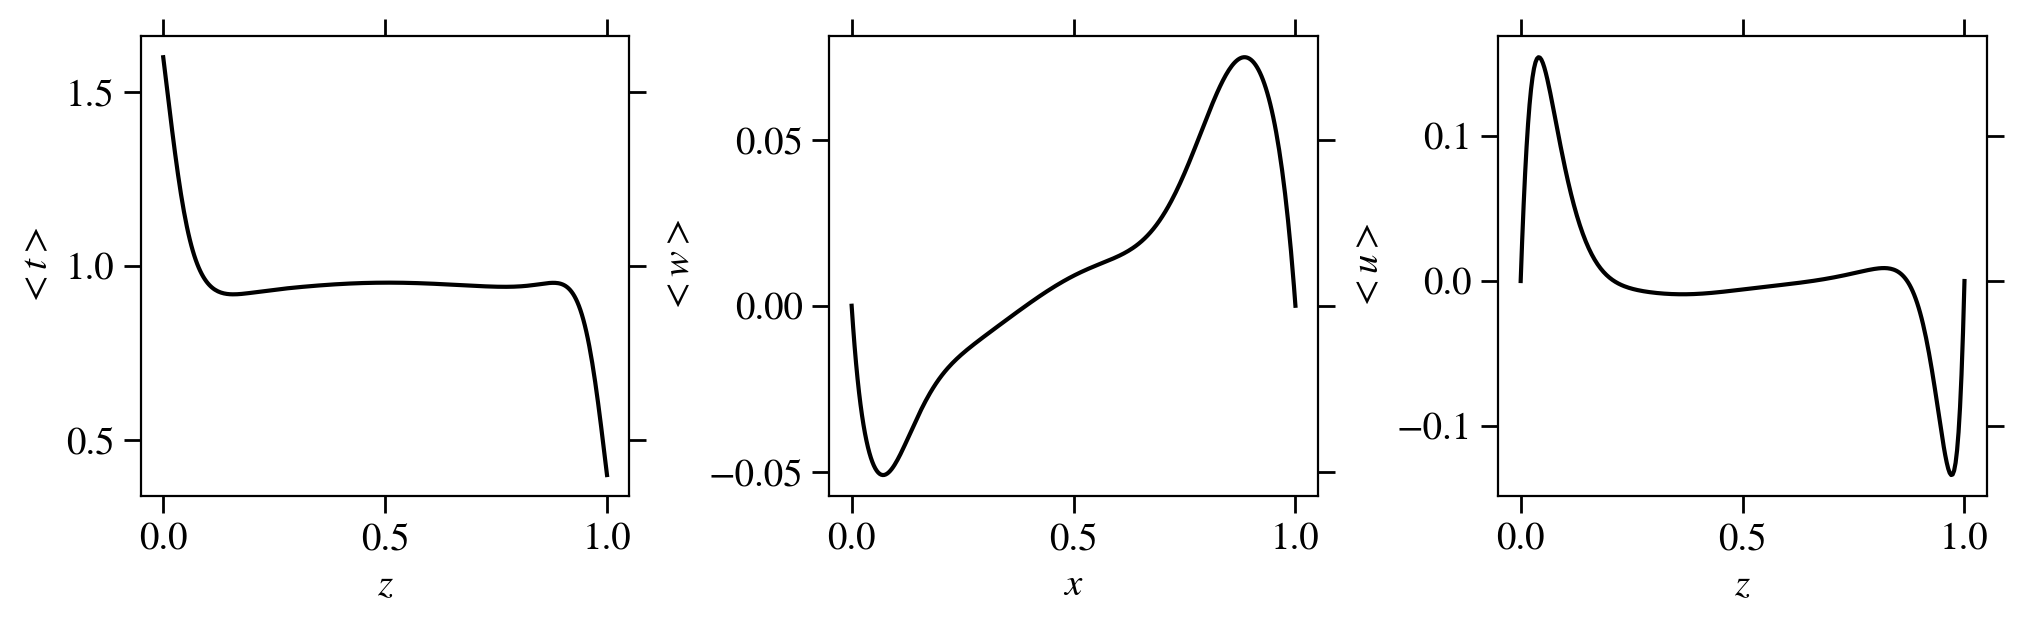

<Figure size 800x600 with 0 Axes>

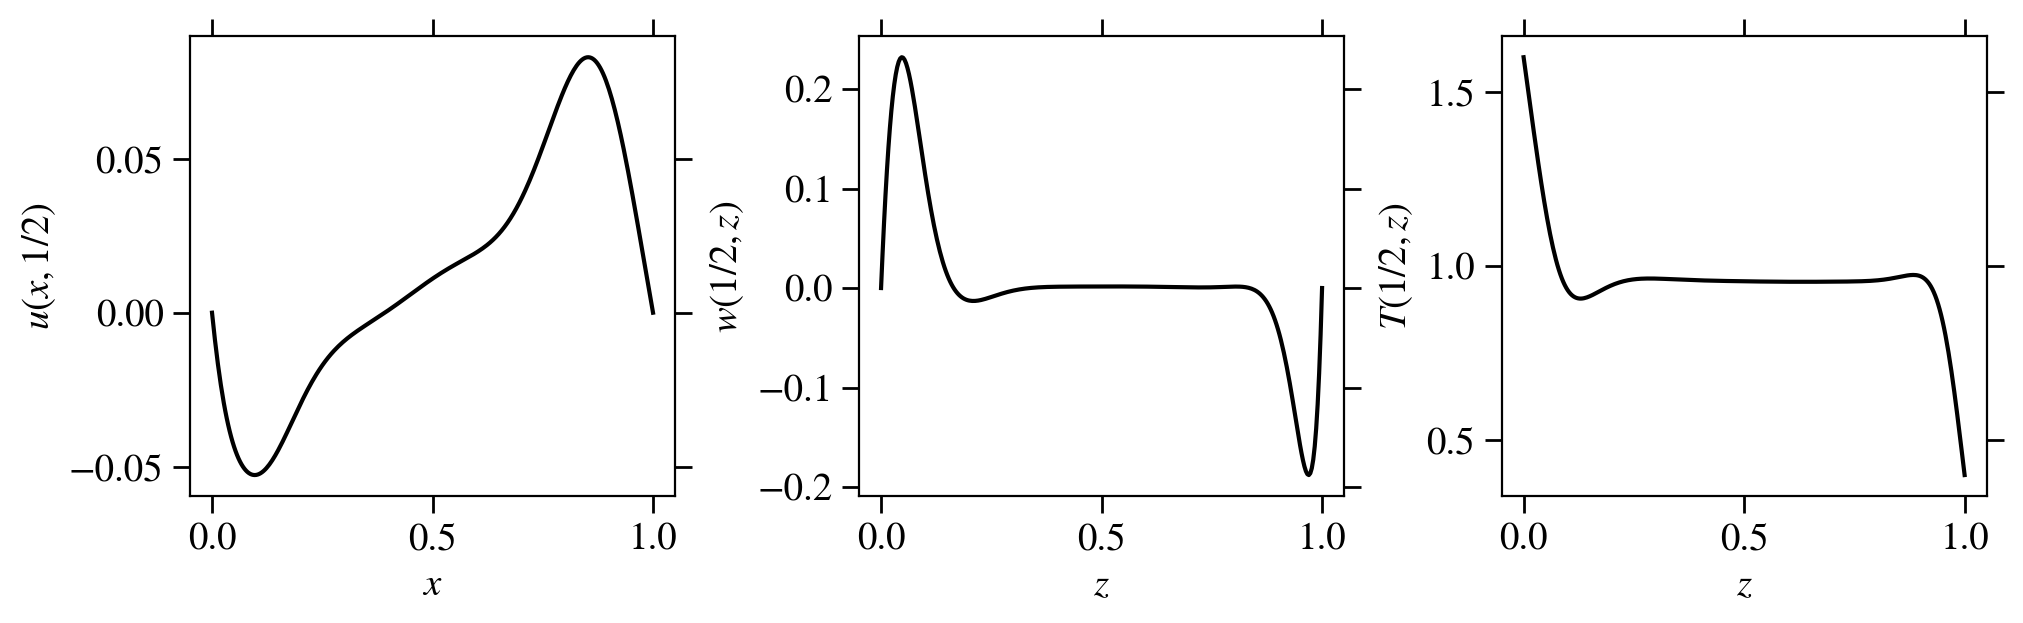

<Figure size 800x600 with 0 Axes>

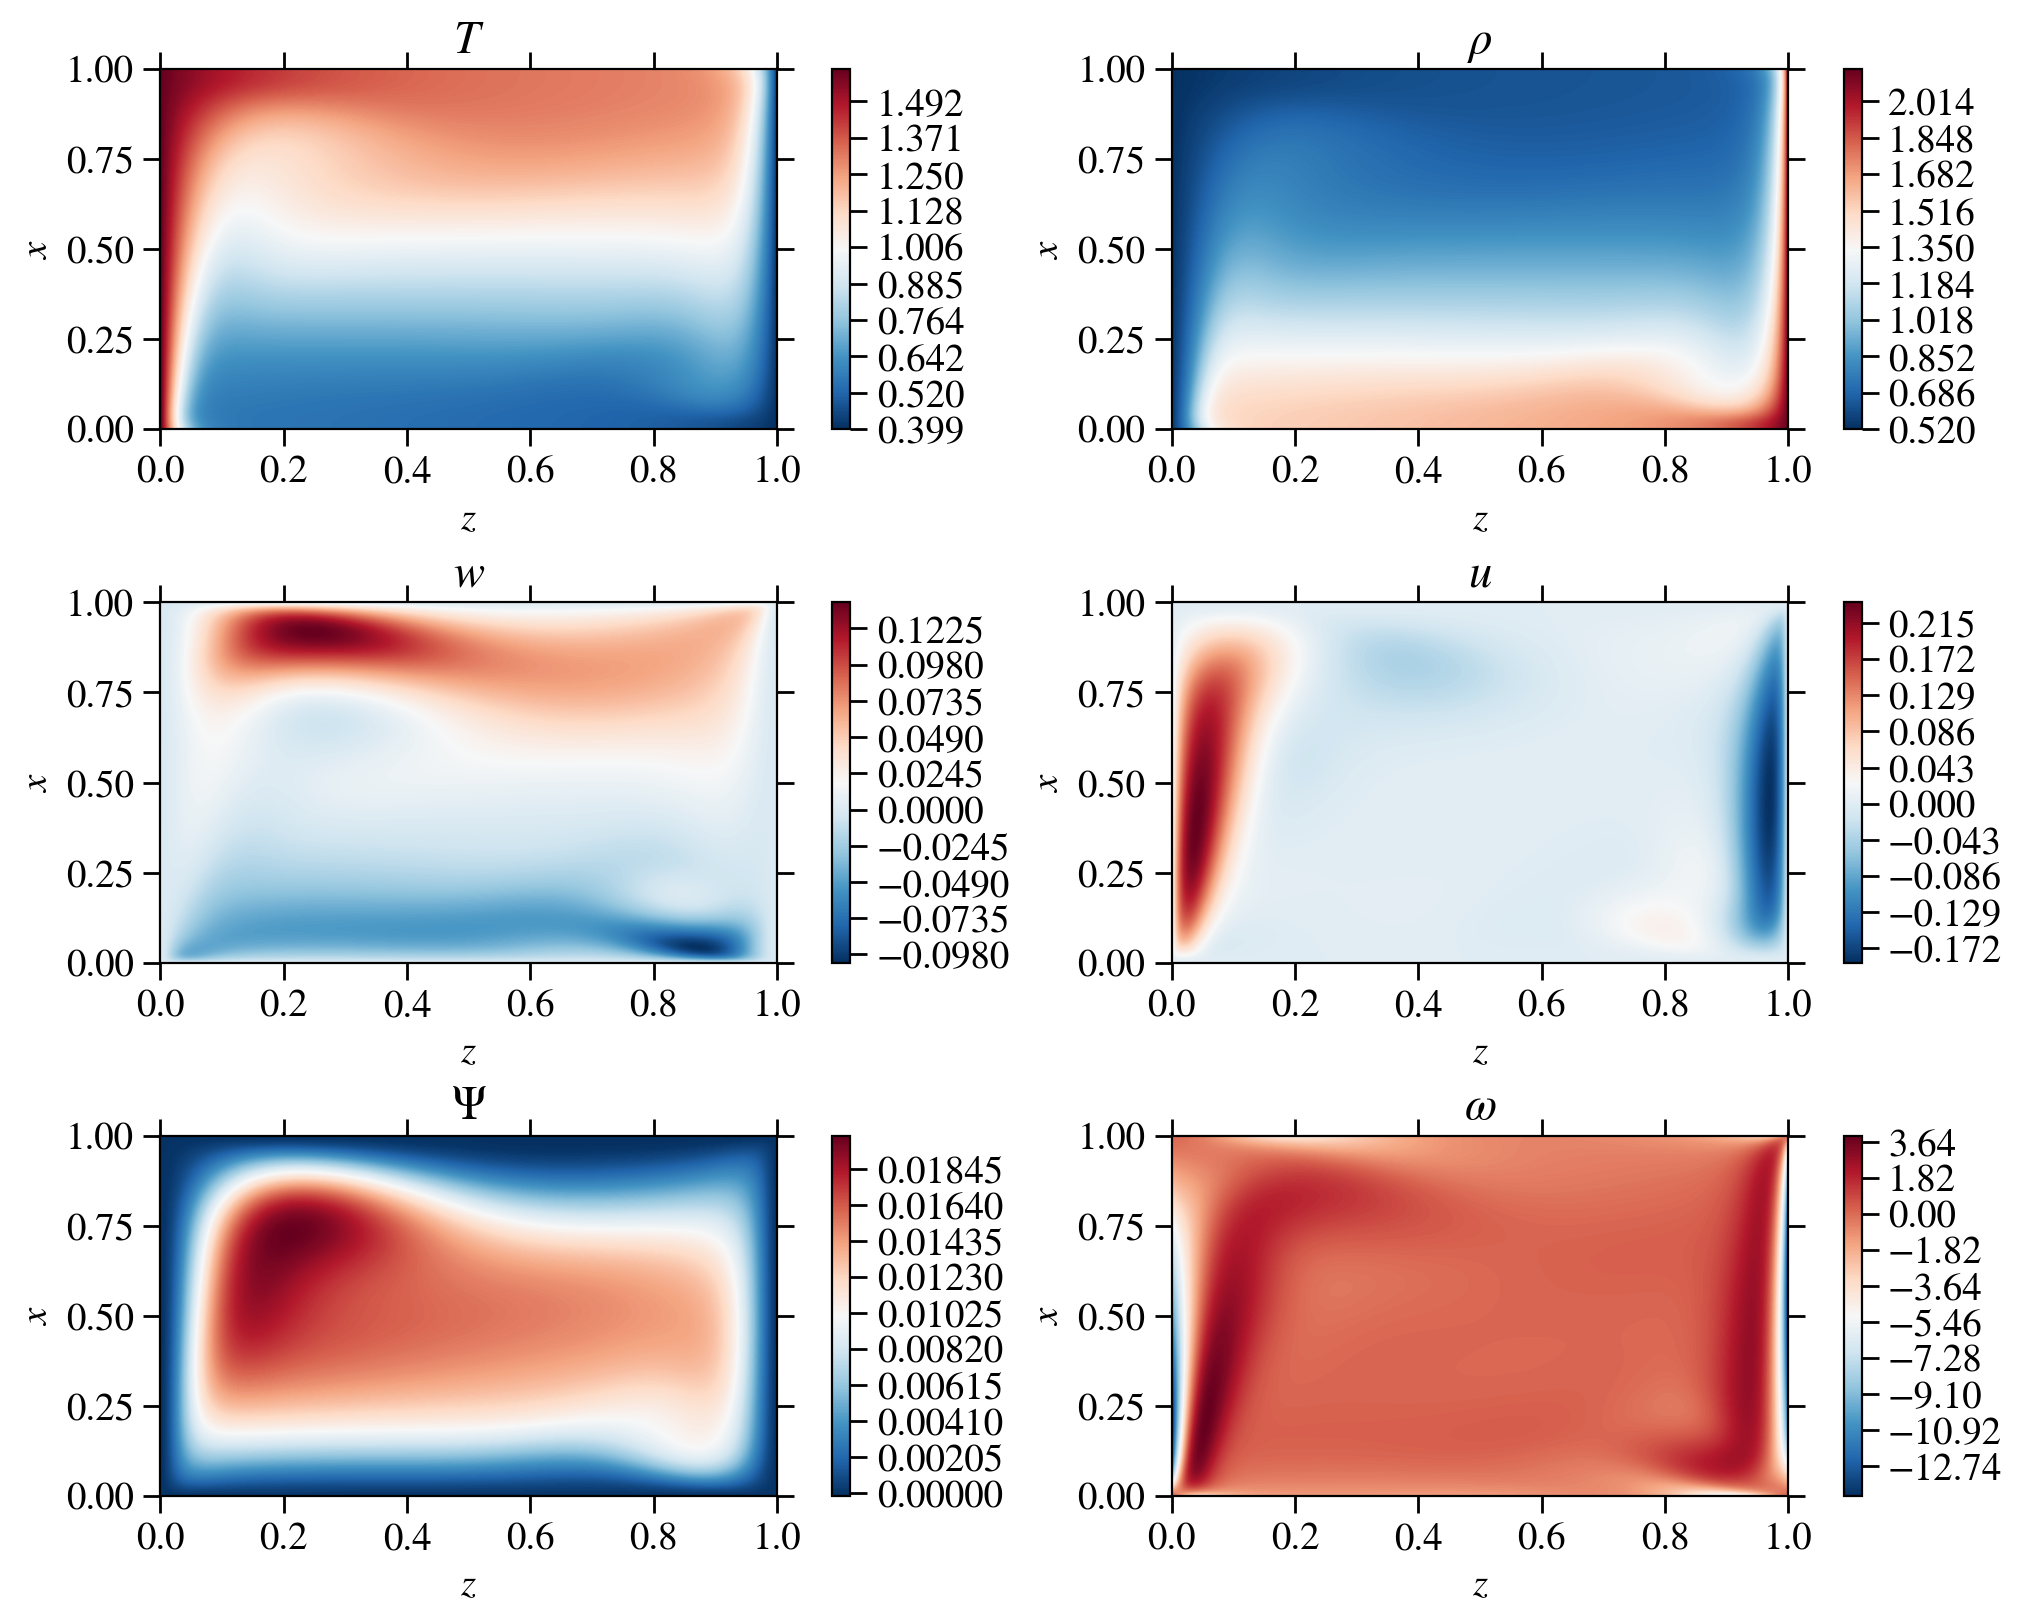

In [3]:
L = 1
T_ref = 1
T_hot = 1.6
T_cold = 0.4
Nx = 301
Nz = 301
Re = 1532.13
Pr = 0.71
Ec = 0.016
ka_factor = Re*Pr*Ec

fol = 'planes'
fol_full = 'restart'
timestamp = 2000000

x = np.fromfile(f"{fol}/x.bin")  # size Nx
y = np.fromfile(f"{fol}/y.bin")  # size Nz
z = np.fromfile(f"{fol}/z.bin")  # size Nz

imax=np.size(x)
jmax=np.size(y)
kmax=np.size(z)

temp = np.fromfile(
    f"{fol}/ypl.1.t.{timestamp:07d}.bin"
).reshape(Nz, Nx).T

rho = np.fromfile(
    f"{fol}/ypl.1.r.{timestamp:07d}.bin"
).reshape(Nz, Nx).T

u = np.fromfile(
    f"{fol}/ypl.1.u.{timestamp:07d}.bin"
).reshape(Nz, Nx).T

w = np.fromfile(
    f"{fol}/ypl.1.w.{timestamp:07d}.bin"
).reshape(Nz, Nx).T

ka = np.fromfile(
    f"{fol}/ypl.1.ka.{timestamp:07d}.bin"
).reshape(Nz, Nx).T

psi, omega = streamfunction_from_uw(u, w, x, z)

############## Max/Min rho ##############

Rho_hot = 1/T_hot
Rho_cold = 1/T_cold

print("Rho_hot =", Rho_hot)
print("Rho_cold =", Rho_cold) 

############## Max Psi ###############

ix_mid = np.argmin(np.abs(x - 0.5))
iz_mid = np.argmin(np.abs(z - 0.5))

psi_mid = psi[ix_mid, iz_mid]
print("psi_mid × 1e2 =", psi_mid * 1e2)

# maximum magnitude and its location
idx = np.unravel_index(np.argmax(np.abs(psi)), psi.shape)
psi_1 = psi[idx]

# map back to physical coordinates
ix = idx[0] + 1
iz = idx[1] + 1

print("psi_1 =", psi_1)
print("location: x =", x[ix], ", z =", z[iz])

############## Max Vel ###############

i_mid = np.argmin(np.abs(z - 0.5))

w_slice = w[:,i_mid]          # u(x,1/2)
w_max = np.max(w_slice)
z_wmax = np.argmax(w_slice)
z_wmax = z[z_wmax]

u_slice = u[i_mid,:]          # w(1/2, z)
u_max = np.max(u_slice)
i_umax = np.argmax(u_slice)
z_umax = z[i_umax]

temp_slice = temp[i_mid,:]          # w(1/2, z)
temp_max = np.max(temp_slice)
i_tempmax = np.argmax(temp_slice)
z_tempmax = z[i_tempmax]

print(f"w_max(x,1/2) × 1e2 = {w_max * 1e2:.5f}  at z = {z_wmax:.3f}")
print(f"u_max(1/2,z) × 1e1 = {u_max * 1e1:.5f}  at z = {z_umax:.3f}")

############## Nusselt ###############

DeltaT = T_hot - T_cold  # 1.0 if 1.5/0.5

dz = z[1] - z[0]         # wall-normal spacing (your naming)
dx = x[1] - x[0]         # along-wall spacing

Twall_hot = temp[:, 0]
kawall_hot = ka[:, 0]*ka_factor
dTdn_wall_hot = (-11.0*Twall_hot + 18.0*temp[:, 1] - 9.0*temp[:, 2] + 2.0*temp[:, 3]) / (6.0*dz)   # derivative into the domain
Nu_local_hot = -(kawall_hot/DeltaT) * dTdn_wall_hot    # local Nusselt along the hot wall
Nu0_hot = np.sum(Nu_local_hot) * dx             # mean Nu on hot wall

Twall_cold = temp[:, -1]
kawall_cold = ka[:, -1]*ka_factor
dTdn_wall_cold = (-11.0*Twall_cold + 18.0*temp[:, -2] - 9.0*temp[:, -3] + 2.0*temp[:, -4]) / (6.0*dz)   # derivative into the domain
Nu_local_cold = (kawall_cold/DeltaT) * dTdn_wall_cold    # local Nusselt along the hot wall
Nu0_cold = np.sum(Nu_local_cold) * dx             # mean Nu on hot wall

Nu_half_hot = Nu_local_hot[len(Nu_local_hot)//2]    # local Nu at mid-height on hot wall
Nu_half_cold = Nu_local_cold[len(Nu_local_cold)//2]    # local Nu at mid-height on hot wall

print("Nu_wall_hot =", Nu0_hot) 
print("Nu_wall_cold =", Nu0_cold) 
print(f"Nu_wall_hot_1/2 = {Nu_half_hot:.6f}")
print(f"Nu_wall_cold_1/2 = {Nu_half_cold:.6f}")

############## Average ###############

temp_avg = np.mean(temp, axis=0)
u_avg = np.mean(u, axis=0)
w_avg = np.mean(w, axis=1)

############## PLOT ###############

fig, ax = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

plt.figure()
ax[0].plot(z, temp_avg, '-k')
ax[0].set_xlabel("$z$")
ax[0].set_ylabel("$<t>$")

ax[1].plot(z, w_avg, '-k')
ax[1].set_xlabel("$x$")
ax[1].set_ylabel("$<w>$")

ax[2].plot(z, u_avg, '-k')
ax[2].set_xlabel("$z$")
ax[2].set_ylabel("$<u>$")


fig, ax = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)

plt.figure()
ax[0].plot(x, w_slice, '-k')
ax[0].set_xlabel("$x$")
ax[0].set_ylabel("$u(x,1/2)$")

ax[1].plot(z, u_slice, '-k')
ax[1].set_xlabel("$z$")
ax[1].set_ylabel("$w(1/2,z)$")

ax[2].plot(z, temp_slice, '-k')
ax[2].set_xlabel("$z$")
ax[2].set_ylabel("$T(1/2,z)$")

Z, X = np.meshgrid(z, x, indexing="xy")  

fig, axs = plt.subplots(3, 2, figsize=(10, 8), constrained_layout=True)

# --- Temperature ---
c0 = axs[0,0].contourf(Z, X, temp, levels=1000, cmap="RdBu_r")
axs[0,0].set_xlabel("$z$")
axs[0,0].set_ylabel("$x$")
axs[0,0].set_title("$T$")
fig.colorbar(c0, ax=axs[0,0])

# --- Density ---
c1 = axs[0,1].contourf(Z, X, rho, levels=1000, cmap="RdBu_r")
axs[0,1].set_xlabel("$z$")
axs[0,1].set_ylabel("$x$")
axs[0,1].set_title(r"$\rho$")
fig.colorbar(c1, ax=axs[0,1])

# --- u velocity ---
c2 = axs[1,0].contourf(Z, X, w, levels=1000, cmap="RdBu_r")
axs[1,0].set_xlabel("$z$")
axs[1,0].set_ylabel("$x$")
axs[1,0].set_title("$w$")
fig.colorbar(c2, ax=axs[1,0])

# --- w velocity ---
c3 = axs[1,1].contourf(Z, X, u, levels=1000, cmap="RdBu_r")
axs[1,1].set_xlabel("$z$")
axs[1,1].set_ylabel("$x$")
axs[1,1].set_title("$u$")
fig.colorbar(c3, ax=axs[1,1])

# --- Psi ---
c4 = axs[2,0].contourf(Z, X, psi, levels=1000, cmap="RdBu_r")
axs[2,0].set_xlabel("$z$")
axs[2,0].set_ylabel("$x$")
axs[2,0].set_title("$\Psi$")
fig.colorbar(c4, ax=axs[2,0])

# --- omega ---
c5 = axs[2,1].contourf(Z, X, omega, levels=1000, cmap="RdBu_r")
axs[2,1].set_xlabel("$z$")
axs[2,1].set_ylabel("$x$")
axs[2,1].set_title("$\omega$")
fig.colorbar(c5, ax=axs[2,1])

plt.show()
